In [57]:
import librosa
import numpy as np
import pandas as pd
import parselmouth
from scipy.signal import find_peaks
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import correlate

In [22]:
# Function to load an audio file
def load_audio(file_path):
    audio, sample_rate = librosa.load(file_path)
    return audio, sample_rate

In [14]:
def generate_tess_report(db_directory):
    """
    Generates a report from the TESS database directory, listing unique voice actors, words, and emotions.

    Args:
    db_directory (str): Path to the TESS database directory.
    """
    # Initialize sets to store unique words, emotions, and voice actors
    words = set()
    emotions = set()
    voice_actors = set()

    # Check if the directory exists
    if not os.path.exists(db_directory):
        print(f"The directory {db_directory} does not exist.")
        return

    # Iterate over all files in the database directory
    for filename in os.listdir(db_directory):
        if filename.endswith('.wav'):
            # Split the filename to extract the voice actor, word, and emotion
            parts = filename.split('_')
            if len(parts) == 3:  # Ensure the filename fits the expected structure
                voice_actor, word, emotion_with_extension = parts
                emotion = emotion_with_extension.split('.')[0]  # Remove the file extension

                # Add the extracted information to the sets
                voice_actors.add(voice_actor)
                words.add(word)
                emotions.add(emotion)

    # Print the report
    print("TESS Database Report:")
    print("Voice Actors:", voice_actors)
    print("Words Spoken:", sorted(words))  # Sorting for better readability
    print("Emotions Conveyed:", sorted(emotions))  # Sorting for better readability

##### Pre Proccessing

In [13]:
def generate_tess_report_as_table(db_directory):
    """
    Generates a report from the TESS database directory in a table format, listing unique voice actors, words, and emotions.

    Args:
    db_directory (str): Path to the TESS database directory.
    """
    # Initialize lists to store words, emotions, and voice actors
    words = []
    emotions = []
    voice_actors = []

    # Check if the directory exists
    if not os.path.exists(db_directory):
        print(f"The directory {db_directory} does not exist.")
        return

    # Iterate over all files in the database directory
    for filename in os.listdir(db_directory):
        if filename.endswith('.wav'):
            # Split the filename to extract the voice actor, word, and emotion
            parts = filename.split('_')
            if len(parts) == 3:  # Ensure the filename fits the expected structure
                voice_actor, word, emotion_with_extension = parts
                emotion = emotion_with_extension.split('.')[0]  # Remove the file extension

                # Add the extracted information to the lists
                voice_actors.append(voice_actor)
                words.append(word)
                emotions.append(emotion)

    # Create a DataFrame
    data = {
        'Voice Actor': voice_actors,
        'Word': words,
        'Emotion': emotions
    }
    df = pd.DataFrame(data)

    # Aggregate the data to count occurrences
    report_df = df.groupby(['Voice Actor', 'Word', 'Emotion']).size().reset_index(name='Count')

    # Print the DataFrame in a tabular format
    print(report_df)

In [11]:
db_directory = 'tess_database/dataverse_files'
generate_tess_report(db_directory)

     Voice Actor   Word  Emotion  Count
0            OAF   back    angry      1
1            OAF   back  disgust      1
2            OAF   back     fear      1
3            OAF   back    happy      1
4            OAF   back  neutral      1
...          ...    ...      ...    ...
2795         YAF  youth     fear      1
2796         YAF  youth    happy      1
2797         YAF  youth  neutral      1
2798         YAF  youth       ps      1
2799         YAF  youth      sad      1

[2800 rows x 4 columns]


##### Exploratory analysis

In [29]:
def summarize_audio_files(db_directory):
    """
    Summarizes key characteristics of audio files in the TESS database.

    Args:
    db_directory (str): Path to the TESS database directory.

    Returns:
    pandas.DataFrame: A DataFrame containing the emotion, duration, and average intensity of each audio file.
    """
    summaries = []

    # Iterate over all files in the database directory
    for filename in os.listdir(db_directory):
        if filename.endswith('.wav'):
            # Extract emotion from the filename
            parts = filename.split('_')
            if len(parts) == 3:
                emotion = parts[2].split('.')[0]

                # Load the audio file
                file_path = os.path.join(db_directory, filename)
                y, sr = load_audio(file_path)

                # Calculate duration and average intensity
                duration = librosa.get_duration(y=y, sr=sr)
                intensity = np.mean(librosa.feature.rms(y=y))

                # Calculate pitch
                pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
                pitch = np.mean(pitches[pitches > 0])  # Average non-zero pitch values

                # Speech rate estimation (placeholder, requires actual implementation)
                # speech_rate = estimate_speech_rate(y, sr)

                # Loudness estimation (placeholder, requires actual implementation)
                # loudness = estimate_loudness(y, sr)

                # Load audio with Parselmouth for jitter and shimmer
                snd = parselmouth.Sound(file_path)
                pointProcess = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", 75, 500)
                jitter = parselmouth.praat.call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
                shimmer = parselmouth.praat.call([snd, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)

                # Append summary to the list
                summaries.append({
                    'Filename': filename,
                    'Emotion': emotion,
                    'Duration': duration,
                    'Intensity': intensity,
                    'Pitch': pitch,
                    # 'SpeechRate': speech_rate,  # Uncomment when implemented
                    # 'Loudness': loudness,  # Uncomment when implemented
                    'Jitter': jitter,
                    'Shimmer': shimmer
                })

    # Create a DataFrame from the summaries
    df = pd.DataFrame(summaries)
    return df

In [18]:
def visualize_emotion_distribution(df):
    """
    Visualizes the distribution of emotions in the TESS database.

    Args:
    df (pandas.DataFrame): DataFrame containing the emotion for each audio file.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Emotion', order=df['Emotion'].value_counts().index)
    plt.title('Emotion Distribution in TESS Database')
    plt.ylabel('Count')
    plt.xlabel('Emotion')
    plt.xticks(rotation=45)
    plt.show()

In [19]:
def visualize_duration_distribution(df):
    """
    Visualizes the distribution of audio file durations in the TESS database.

    Args:
    df (pandas.DataFrame): DataFrame containing the duration for each audio file.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='Duration', bins=30, kde=True)
    plt.title('Duration Distribution of Audio Files')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    plt.show()

In [20]:
def visualize_intensity_distribution(df):
    """
    Visualizes the distribution of intensities in the TESS database.

    Args:
    df (pandas.DataFrame): DataFrame containing the average intensity for each audio file.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='Intensity', bins=30, kde=True)
    plt.title('Intensity Distribution of Audio Files')
    plt.xlabel('Average Intensity')
    plt.ylabel('Count')
    plt.show()

In [24]:
def visualize_pitch_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Emotion', y='Pitch', data=df)
    plt.title('Pitch Distribution by Emotion')
    plt.xlabel('Emotion')
    plt.ylabel('Pitch (Hz)')
    plt.xticks(rotation=45)
    plt.show()

In [25]:
def visualize_speech_rate_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='SpeechRate', bins=30, kde=True)
    plt.title('Speech Rate Distribution of Audio Files')
    plt.xlabel('Speech Rate (words/minute)')
    plt.ylabel('Count')
    plt.show()

In [26]:
def visualize_loudness_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='Loudness', bins=30, kde=True)
    plt.title('Loudness Distribution of Audio Files')
    plt.xlabel('Loudness (LUFS)')
    plt.ylabel('Count')
    plt.show()

In [27]:
def visualize_jitter_shimmer_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Jitter', y='Shimmer', hue='Emotion', data=df)
    plt.title('Jitter vs. Shimmer Distribution by Emotion')
    plt.xlabel('Jitter (%)')
    plt.ylabel('Shimmer (%)')
    plt.show()

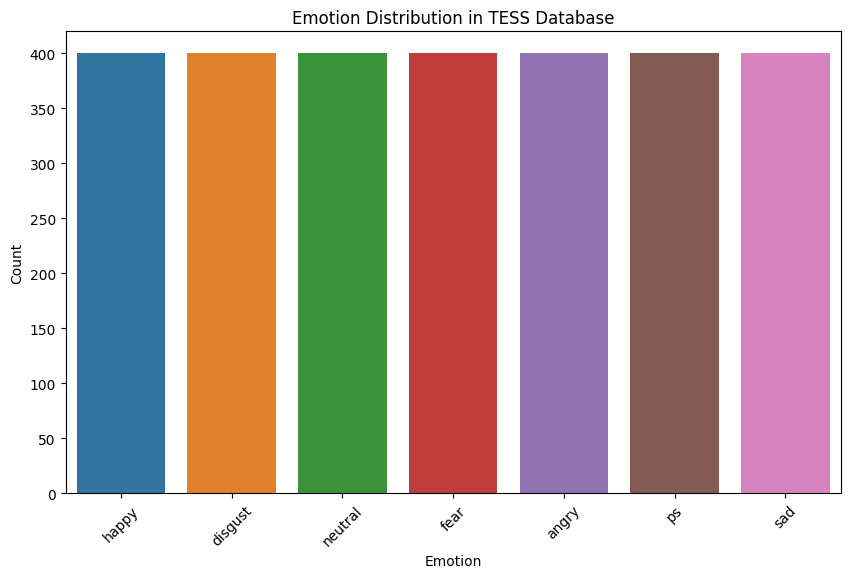

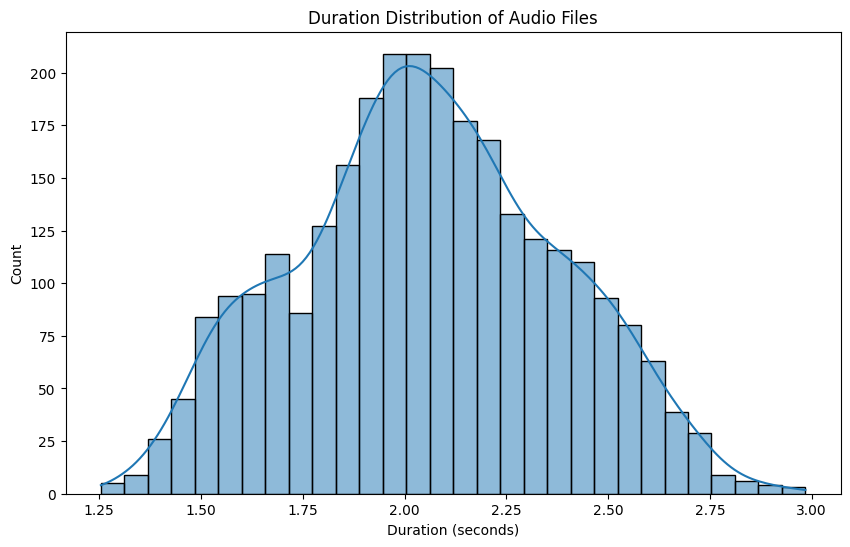

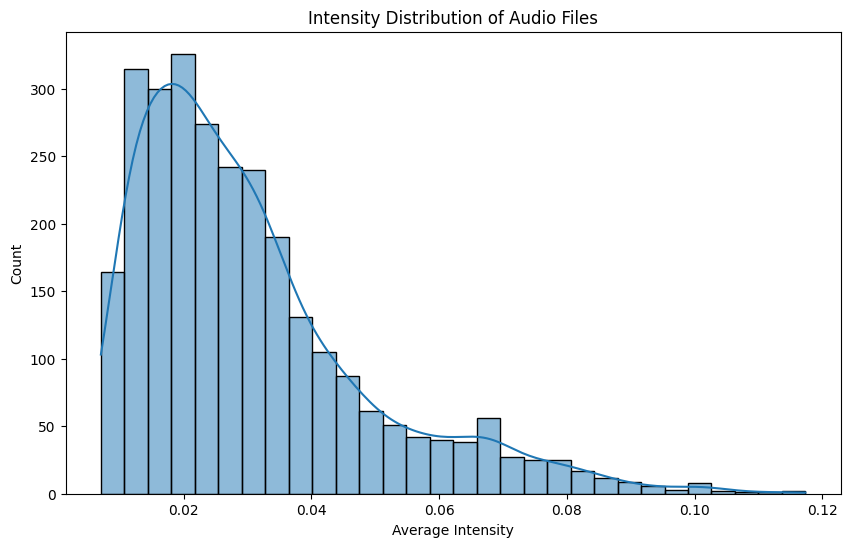

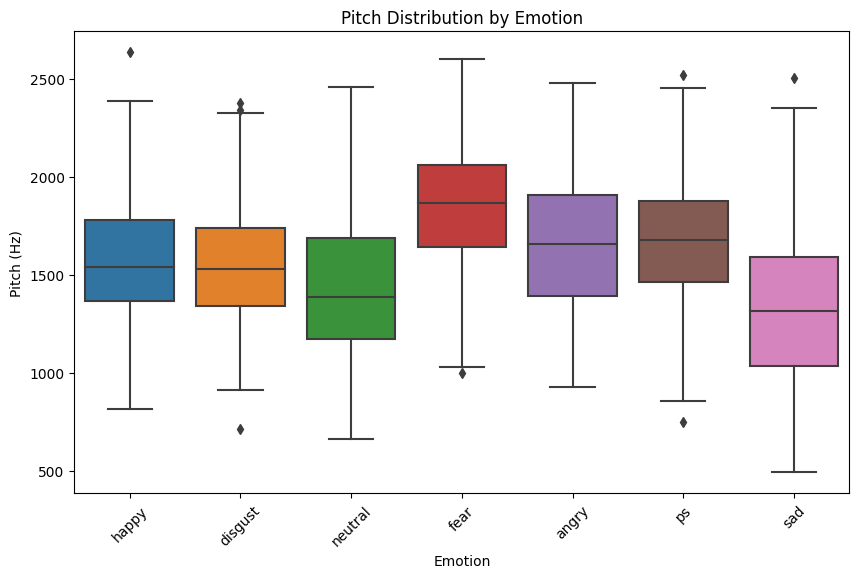

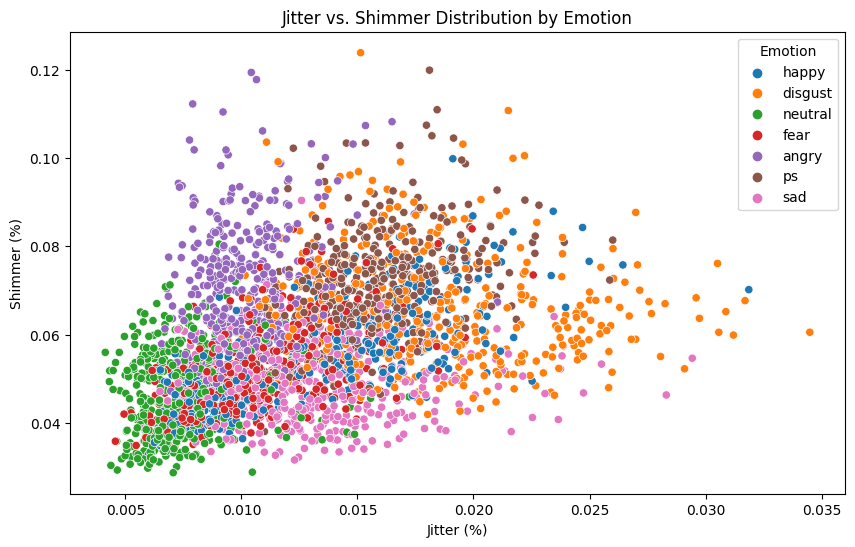

In [31]:
df_summary = summarize_audio_files(db_directory)
visualize_emotion_distribution(df_summary)
visualize_duration_distribution(df_summary)
visualize_intensity_distribution(df_summary)
visualize_pitch_distribution(df_summary)
#visualize_loudness_distribution(df_summary)
visualize_jitter_shimmer_distribution(df_summary)

##### Prosodic feature set extraction

In [32]:
# Function to extract pitch
def extract_pitch(y, sr):
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    pitch = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch.append(pitches[index, t])
    pitch = np.trim_zeros(np.array(pitch))
    return np.mean(pitch), np.std(pitch)  # Returning mean and standard deviation

In [33]:
# Function to extract energy
def extract_energy(y):
    frame_length = 1024
    energy = np.array([
        np.sum(np.abs(y[i:i+frame_length]**2))
        for i in range(0, len(y), frame_length)
    ])
    return np.mean(energy), np.std(energy)  # Returning mean and standard deviation

In [34]:
# Function to extract duration features
def extract_duration_features(y, sr):
    duration = librosa.get_duration(y=y, sr=sr)
    tempogram = librosa.feature.tempogram(y=y, sr=sr)
    speech_rate = np.mean(tempogram)  # Approximation for speech rate
    return duration, speech_rate

In [35]:
# Function to extract silence duration
def extract_silence_duration(y, sr, threshold=0.02):
    y_abs = np.abs(y)
    silence_duration = np.sum(y_abs < threshold) / sr
    return silence_duration

In [36]:
# Function to calculate voiced vs. unvoiced speech duration
def voiced_unvoiced(y, sr, hop_length=512):
    # Using zero-crossing rate to estimate voiced and unvoiced segments
    zero_crossings = librosa.feature.zero_crossing_rate(y, frame_length=hop_length, hop_length=hop_length)
    voiced = np.sum(zero_crossings > 0.1) * hop_length / sr  # Threshold for voiced segments
    unvoiced = np.sum(zero_crossings <= 0.1) * hop_length / sr  # Threshold for unvoiced segments
    return voiced, unvoiced

In [37]:
# Function to extract pitch variation
def extract_pitch_variation(y, sr):
    pitches, _ = librosa.core.piptrack(y=y, sr=sr)
    pitch_variation = np.var(pitches)
    return pitch_variation

In [38]:
# Main function to extract all features
def extract_prosodic_features(file_path):
    y, sr = load_audio(file_path)
    mean_pitch, std_pitch = extract_pitch(y, sr)
    mean_energy, std_energy = extract_energy(y)
    duration, speech_rate = extract_duration_features(y, sr)
    silence_duration = extract_silence_duration(y, sr)
    voiced_duration, unvoiced_duration = voiced_unvoiced(y, sr)
    pitch_variation = extract_pitch_variation(y, sr)
    
    features = {
        'mean_pitch': mean_pitch,
        'std_pitch': std_pitch,
        'mean_energy': mean_energy,
        'std_energy': std_energy,
        'duration': duration,
        'speech_rate': speech_rate,
        'silence_duration': silence_duration,
        'voiced_duration': voiced_duration,
        'unvoiced_duration': unvoiced_duration,
        'pitch_variation': pitch_variation
    }
    
    return features

In [41]:
# Initialize an empty list to store feature data
data = []

# Iterate over files in the EmoDB directory
for filename in os.listdir(db_directory):
    if filename.endswith(".wav"):  # Assuming the files are in WAV format
        file_path = os.path.join(db_directory, filename)
        # Extract features from the audio file
        features = extract_prosodic_features(file_path)  # Your feature extraction function
        # Include the filename or other identifiers as needed
        features['filename'] = filename
        # Append the features to the data list
        data.append(features)

# Convert the list of feature dictionaries to a DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame to verify
print(df.head())

# Define the path for the output CSV file
output_csv_path = 'features/prosodic_features.csv'

# Write the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

print(f'Features extracted and saved to {output_csv_path}')

    mean_pitch    std_pitch  mean_energy  std_energy  duration  speech_rate  \
0   449.610199   381.894135     9.676556   11.913024  2.075601     0.064879   
1  1007.365051  1288.699097     0.327053    0.572303  2.345760     0.097476   
2   792.386292  1063.287964     0.588500    0.856471  1.794921     0.059025   
3   708.017578  1036.089600     0.109407    0.107576  1.861633     0.159514   
4   516.532471   480.635956     4.721364    6.218035  1.650204     0.054590   

   silence_duration  voiced_duration  unvoiced_duration  pitch_variation  \
0          0.940317         0.696599           1.393197     17896.482422   
1          1.993787         0.882358           1.486077     47069.945312   
2          1.316961         0.255420           1.555737     13634.870117   
3          1.706621         0.487619           1.393197     12398.823242   
4          0.870113         0.673379           0.998458     52227.867188   

               filename  
0    YAF_wire_happy.wav  
1   OAF_fat_disg

In [ ]:
# Example usage
file_path = 'path_to_your_audio_file.wav'
features = extract_features(file_path)
print(features)

##### Acoustic feature set extraction

In [42]:
# Function to extract MFCC features
def extract_mfcc(audio, sample_rate, n_mfcc=13):
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return np.mean(mfccs.T, axis=0)

In [52]:
# Function to extract LPCC features
def extract_lpcc(audio, sample_rate, n_lpcc=13):
    lpccs = librosa.lpc(y=audio, order=n_lpcc)
    return lpccs

In [44]:
# Function to extract LFPC features
def extract_lfpc(audio, sample_rate, n_bands=40):
    stft = np.abs(librosa.stft(audio))
    lfpcs = librosa.feature.melspectrogram(S=stft**2, sr=sample_rate, n_mels=n_bands)
    return np.mean(lfpcs.T, axis=0)

In [45]:
# Function to extract GFCC features
def extract_gfcc(audio, sample_rate, n_gfcc=13):
    gfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_gfcc, htk=True)
    return np.mean(gfccs.T, axis=0)

In [46]:
# Function to extract formants
def extract_formants(audio, sample_rate):
    pitches, magnitudes = librosa.core.piptrack(y=audio, sr=sample_rate)
    formants = np.max(magnitudes, axis=0)
    return formants

In [47]:
# Main function to extract all features
def extract_acoustic_features(file_path):
    audio, sample_rate = load_audio(file_path)
    features = {}
    features['mfcc'] = extract_mfcc(audio, sample_rate)
    features['lpcc'] = extract_lpcc(audio, sample_rate)
    features['lfpc'] = extract_lfpc(audio, sample_rate)
    features['gfcc'] = extract_gfcc(audio, sample_rate)
    features['formants'] = extract_formants(audio, sample_rate)
    return features

In [75]:
# Initialize an empty list to store feature data
data = []

# Iterate over files in the EmoDB directory
for filename in os.listdir(db_directory):
    if filename.endswith(".wav"):  # Assuming the files are in WAV format
        file_path = os.path.join(db_directory, filename)
        # Extract features from the audio file
        features = extract_acoustic_features(file_path)  # Your feature extraction function
        # Include the filename or other identifiers as needed
        features['filename'] = filename
        # Append the features to the data list
        data.append(features)

# Convert the list of feature dictionaries to a DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame to verify
print(df.head())

# Define the path for the output CSV file
output_csv_path = 'features/acoustic_features.csv'

# Write the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

print(f'Features extracted and saved to {output_csv_path}')

                                                mfcc  \
0  [-300.5379, 40.605106, -28.108757, 17.45625, -...   
1  [-426.9512, 71.14616, 3.221315, -10.768615, 13...   
2  [-441.6265, 92.82772, 19.227163, -14.2388115, ...   
3  [-515.32117, 59.07907, 16.712137, 10.546044, 1...   
4  [-295.1762, 41.771236, -15.355103, 15.900852, ...   

                                                lpcc  \
0  [1.0, -1.7448161, 1.0000771, 0.1465317, -0.435...   
1  [1.0, -0.8589723, -0.024427855, -0.314105, -0....   
2  [1.0, -0.9826942, -0.07148894, -0.59121585, 0....   
3  [1.0, -1.0153912, 0.19047754, -0.6288274, 0.62...   
4  [1.0, -1.2599481, 0.16007785, 0.21459147, 0.06...   

                                                lfpc  \
0  [0.0023599719, 0.49987122, 2.4315553, 2.492736...   
1  [0.0057541984, 0.15236326, 0.28910416, 0.20294...   
2  [0.092098996, 0.15914197, 0.42431548, 0.923114...   
3  [0.0030326215, 0.14114383, 0.04965497, 0.30300...   
4  [0.049695488, 0.19012822, 1.384158, 6.00092

In [ ]:
# Example usage
file_path = 'path_to_your_audio_file.wav'
features = extract_features(file_path)
print(features)

#####  TEO-based feature set extraction

In [54]:
# Function to calculate Teager Energy Operator (TEO)
def teager_energy_operator(signal):
    teo = np.zeros(len(signal))
    for i in range(1, len(signal) - 1):
        teo[i] = signal[i]**2 - signal[i-1] * signal[i+1]
    return teo

In [55]:
# Function to extract TEO-FM-Var feature
def extract_teo_fm_var(signal, sample_rate):
    teo_signal = teager_energy_operator(signal)
    peaks, _ = find_peaks(teo_signal)
    fm_var = np.var(np.diff(peaks) / sample_rate)
    return fm_var

In [58]:
# Function to extract TEO-Auto-Env feature
def extract_teo_auto_env(signal):
    teo_signal = teager_energy_operator(signal)
    auto_corr = correlate(teo_signal, teo_signal, mode='full')
    auto_env = np.max(auto_corr)
    return auto_env / len(signal)  # Normalized

In [68]:
from scipy.signal import butter, filtfilt

def bandpass_filter(signal, lowcut, highcut, fs, order=5):
    """
    Apply a Butterworth bandpass filter to a signal.

    Parameters:
    - signal: The input signal (array-like).
    - lowcut: The lower bound of the frequency range (Hz).
    - highcut: The upper bound of the frequency range (Hz).
    - fs: The sampling rate of the signal (Hz).
    - order: The order of the filter (int).

    Returns:
    - The filtered signal.
    """
    # Nyquist frequency is half the sampling rate
    nyq = 0.5 * fs

    # Compute low and high cutoff frequencies relative to Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq

    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')

    # Apply the filter to the signal using filtfilt
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal

In [71]:
# Function to extract TEO-CB-Auto-Env feature
def extract_teo_cb_auto_env(signal, sample_rate, bands):
    # Assuming 'bands' is a list of tuples indicating frequency bands
    # and a function 'bandpass_filter' applies a bandpass filter to the signal
    teo_cb_auto_env_features = []
    for band in bands:
        filtered_signal = bandpass_filter(signal, band[0], band[1], sample_rate)
        teo_signal = teager_energy_operator(filtered_signal)
        auto_corr = correlate(teo_signal, teo_signal, mode='full')
        teo_cb_auto_env_features.append(np.max(auto_corr) / len(filtered_signal))
    return teo_cb_auto_env_features


In [72]:
# Main function to extract TEO-based features
def extract_teo_features(file_path):
    signal, sample_rate = load_audio(file_path)
    bands = [(300, 800), (800, 2500), (2500, 4000)]
    features = {}
    features['TEO-FM-Var'] = extract_teo_fm_var(signal, sample_rate)
    features['TEO-Auto-Env'] = extract_teo_auto_env(signal)
    features['TEO-CB-Auto-Env'] = extract_teo_cb_auto_env(signal, sample_rate, bands)
    return features

In [76]:
# Initialize an empty list to store feature data
data = []

# Iterate over files in the EmoDB directory
for filename in os.listdir(db_directory):
    if filename.endswith(".wav"):  # Assuming the files are in WAV format
        file_path = os.path.join(db_directory, filename)
        # Extract features from the audio file
        features = extract_teo_features(file_path)  # Your feature extraction function
        # Include the filename or other identifiers as needed
        features['filename'] = filename
        # Append the features to the data list
        data.append(features)

# Convert the list of feature dictionaries to a DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame to verify
print(df.head())

# Define the path for the output CSV file
output_csv_path = 'features/teo_features.csv'

# Write the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

print(f'Features extracted and saved to {output_csv_path}')

     TEO-FM-Var  TEO-Auto-Env  \
0  8.148941e-09  7.400080e-05   
1  3.483438e-09  2.340144e-08   
2  2.912736e-09  1.371484e-08   
3  2.455791e-09  4.446475e-10   
4  6.895127e-09  1.072541e-05   

                                     TEO-CB-Auto-Env              filename  
0  [3.1903647760844913e-07, 6.758846390619847e-06...    YAF_wire_happy.wav  
1  [5.274654823426008e-10, 1.6972485428475463e-09...   OAF_fat_disgust.wav  
2  [1.083785021807403e-09, 1.0896821547269573e-09...  OAF_bought_happy.wav  
3  [1.4342673041021999e-11, 7.459791906570824e-12...   OAF_fit_neutral.wav  
4  [1.0509178822631239e-07, 1.8938584406448206e-0...     YAF_dead_fear.wav  
Features extracted and saved to features/teo_features.csv


In [ ]:
# Example usage
# signal: Loaded audio signal
# sample_rate: Sample rate of the audio signal
# bands: List of tuples indicating critical bands
features = extract_teo_features(signal, sample_rate, )
print(features)

##### Voice quality feature set extraction

In [85]:
# Function to extract Jitter
def extract_jitter(sound, pointProcess):
    #jitter = sound.to_jitter("local", 0.01, 0.02, 0.0001, 0.02, 75)
    jitter = parselmouth.praat.call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    return np.mean(jitter)

In [87]:
# Function to extract Shimmer
def extract_shimmer(sound, pointProcess):
    #shimmer = sound.to_shimmer("local", 0.01, 0.02, 0.0001, 0.02, 75, 1.6)
    shimmer = parselmouth.praat.call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    return np.mean(shimmer)

In [89]:
# Function to extract Harmonics-to-Noise Ratio (HNR)
def extract_hnr(sound):
    hnr = sound.to_harmonicity() #"cc", 0.01, 75, 0.1
    hnr_values = hnr.values
    return np.mean(hnr_values[hnr_values != -200]) # Compute average HNR, ignoring undefined values (which can be -200 in Parselmouth)


In [90]:
# Main function to extract voice quality features
def extract_voice_quality_features(file_path):
    # Load audio with Parselmouth for jitter and shimmer
    sound = parselmouth.Sound(file_path)
    pointProcess = parselmouth.praat.call(sound, "To PointProcess (periodic, cc)", 75, 500)
    features = {}
    features['Jitter'] = extract_jitter(sound, pointProcess)
    features['Shimmer'] = extract_shimmer(sound, pointProcess)
    features['HNR'] = extract_hnr(sound)
    return features

In [91]:
# Initialize an empty list to store feature data
data = []

# Iterate over files in the EmoDB directory
for filename in os.listdir(db_directory):
    if filename.endswith(".wav"):  # Assuming the files are in WAV format
        file_path = os.path.join(db_directory, filename)
        # Extract features from the audio file
        features = extract_voice_quality_features(file_path)  # Your feature extraction function
        # Include the filename or other identifiers as needed
        features['filename'] = filename
        # Append the features to the data list
        data.append(features)

# Convert the list of feature dictionaries to a DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame to verify
print(df.head())

# Define the path for the output CSV file
output_csv_path = 'features/voice_quality_features.csv'

# Write the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

print(f'Features extracted and saved to {output_csv_path}')

     Jitter   Shimmer        HNR              filename
0  0.007279  0.047687  19.449573    YAF_wire_happy.wav
1  0.017873  0.088790  11.098338   OAF_fat_disgust.wav
2  0.018220  0.073238  15.321698  OAF_bought_happy.wav
3  0.010489  0.057556  17.720841   OAF_fit_neutral.wav
4  0.012555  0.055561  14.943881     YAF_dead_fear.wav
Features extracted and saved to features/voice_quality_features.csv


In [ ]:
# Example usage
file_path = 'path_to_your_audio_file.wav'
features = extract_voice_quality_features(file_path)
print(features)

In [106]:
import re
import tensorflow as tf
from hmmlearn import hmm
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.layers import TimeDistributed, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [129]:
def create_label_file(df, filename_column='filename', output_path='features/labels.csv'):
    # Extract the label from the filename (assuming the label is the last part before the ".wav" extension)
    labels = df[filename_column].str.extract(r'([^_]+)\.wav$', flags=re.IGNORECASE)[0]
    
    # Diagnostics: Check the data type and presence of NaN values
    #print(f"Data type of labels: {labels.dtype}")
    #print(f"Number of NaN values: {labels.isna().sum()}")
    #print(labels.head())

    # Reset the index to ensure alignment
    #labels_reset = labels.reset_index(drop=True)

    # Create a new DataFrame with the extracted and reset labels
    labels_df = pd.DataFrame(labels.values, columns=['label'])
    print(labels_df.head())

    # Save the labels DataFrame to a CSV file
    labels_df.to_csv(output_path, index=False)

    return output_path

In [142]:
feature_set = pd.read_csv('features/prosodic_features.csv')
#labels = df['filename'].str.extract(r'([^_]+)\.wav$', flags=re.IGNORECASE)[0]
#dataframe_labels = pd.DataFrame(labels.values, columns=['label'])
#print(f"Data type of labels: {labels.dtype}")
#print(labels.head())
#dataframe_labels
print("Labels were loaded to: " + create_label_file(feature_set))
feature_set.drop(columns=['filename'], inplace=True)
feature_set

     label
0    happy
1  disgust
2    happy
3  neutral
4     fear
Labels were loaded to: features/labels.csv


,mean_pitch,std_pitch,mean_energy,std_energy,duration,speech_rate,silence_duration,voiced_duration,unvoiced_duration,pitch_variation
0,449.61020,381.89413,9.676556,11.913024,2.075601,0.064879,0.940317,0.696599,1.393197,17896.482
1,1007.36505,1288.69910,0.327053,0.572303,2.345760,0.097476,1.993787,0.882358,1.486077,47069.945
2,792.38630,1063.28800,0.588500,0.856471,1.794921,0.059025,1.316961,0.255420,1.555737,13634.870
3,708.01760,1036.08960,0.109407,0.107576,1.861633,0.159514,1.706621,0.487619,1.393197,12398.823
4,516.53250,480.63596,4.721363,6.218035,1.650204,0.054590,0.870113,0.673379,0.998458,52227.867
...,...,...,...,...,...,...,...,...,...,...
2795,708.21240,1139.80480,0.127456,0.114850,2.261134,0.101287,2.052562,0.301859,1.973696,9643.071
2796,887.05615,1270.49730,0.992471,1.117473,1.506576,0.043360,0.930476,0.301859,1.207438,46773.863
2797,616.84344,916.59400,0.254747,0.230110,1.975782,0.080624,1.561270,0.185760,1.811156,18794.928
2798,859.81340,1168.63440,0.485589,0.660081,1.776644,0.167971,1.323401,0.371519,1.416417,20389.207


##### HMM Model

In [150]:
# Function to load and preprocess data
def load_and_preprocess_data(feature_set_path, labels_path):
    X = pd.read_csv(feature_set_path) # Load features
    Y = pd.read_csv(labels_path)
    
    X.drop(columns=['filename'], inplace=True)

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, Y

In [155]:
# Function to train HMM model
def train_hmm(X_train, Y_train, n_components=30):
    # Train a Gaussian HMM for each class
    models = {}
    for label in np.unique(Y_train):
        filtered_X = X_train[Y_train == label]

        # Check the shape of filtered_X
        print(f"Shape of filtered_X for label {label}: {filtered_X.shape}")
        model = hmm.GaussianHMM(n_components=n_components, covariance_type='diag', n_iter=1000)
        model.fit(X_train[Y_train == label])
        models[label] = model
    return models

In [145]:
# Function to evaluate the model
def evaluate_model(models, X_test, Y_test):
    predictions = []
    for sample in X_test:
        log_likelihood = {label: model.score(sample.reshape(-1, 1)) for label, model in models.items()}
        predicted_label = max(log_likelihood, key=log_likelihood.get)
        predictions.append(predicted_label)
    
    report = classification_report(Y_test, predictions, target_names=models.keys())
    print(report)

In [156]:
# Main function to run the analysis
def run_analysis(feature_set_path, labels_path):
    X, Y = load_and_preprocess_data(feature_set_path, labels_path)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    print(X_train.shape)  # Should be (n_samples, n_features)
    print(Y_train.shape)  # Should be (n_samples,)
    
    models = train_hmm(X_train, Y_train)
    #evaluate_model(models, X_test, Y_test)

In [157]:
# Example usage for different feature sets
labels_path = 'features/labels.csv'
feature_sets = ['features/prosodic_features.csv']#, 'lpcc_features.npy', 'teo_features.npy', 'voice_quality_features.npy']
for feature_set in feature_sets:
    print(f"Evaluating feature set: {feature_set}")
    run_analysis(feature_set, labels_path)

Evaluating feature set: features/prosodic_features.csv
(2240, 10)
(2240, 1)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 10 but corresponding boolean dimension is 1

##### ANN Model

In [ ]:
# Function to load and preprocess data
def load_data(feature_file, label_file):
    # Load features and labels
    X = np.load(feature_file)
    y = np.load(label_file)
    
    # Encode labels to integers
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y_encoded, encoder.classes_

In [ ]:
# Function to build ANN model
def build_ann(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# Function to train and evaluate model
def train_and_evaluate(X_train, y_train, X_test, y_test, classes):
    model = build_ann(X_train.shape[1], len(classes))
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    print(classification_report(y_test, y_pred_labels, target_names=classes))

In [ ]:
# Main function to process data, train model, and evaluate
def run_analysis(feature_file, label_file):
    X, y, classes = load_data(feature_file, label_file)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    train_and_evaluate(X_train, y_train, X_test, y_test, classes)

In [ ]:
# Example usage for different feature sets
feature_sets = ['mfcc_features.npy', 'lpcc_features.npy', 'teo_features.npy', 'voice_quality_features.npy']
label_file = 'labels.npy'  # Assuming all feature sets use the same label file
for feature_set in feature_sets:
    print(f"Evaluating feature set: {feature_set}")
    run_analysis(feature_set, label_file)

##### CNN Model

In [ ]:
# Function to load and preprocess data
def load_data(feature_file, label_file):
    X = np.load(feature_file)
    y = np.load(label_file)
    X_padded = pad_sequences(X, padding='post', dtype='float32')
    return X_padded, y

In [ ]:
# Function to build the CNN model with attention mechanism
def build_cnn_with_attention(input_shape, num_classes):
    model = Sequential([
        TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu'), input_shape=input_shape),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
        TimeDistributed(Conv2D(64, kernel_size=(3, 3), activation='relu')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
        TimeDistributed(Flatten()),
        Bidirectional(LSTM(64, return_sequences=True)),
        Attention(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Building the CNN model
def build_cnn(input_shape, output_units):
    model = Sequential([
        TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Flatten()),
        # LSTM layer to learn temporal dependencies
        Bidirectional(LSTM(64, return_sequences=True)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(output_units, activation='sigmoid')  # Using sigmoid for dimensional modeling
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model


In [ ]:
# Function to train and evaluate the model
def train_and_evaluate(X_train, y_train, X_test, y_test):
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], 1)
    num_classes = np.unique(y_train).shape[0]

    model = build_cnn_with_attention(input_shape, num_classes)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc}")

In [ ]:
# Main function to process data, train, and evaluate the model
def run_analysis_for_feature_set(feature_file, label_file):
    X, y = load_data(feature_file, label_file)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_and_evaluate(X_train, y_train, X_test, y_test)

In [ ]:
# Running the analysis for multiple feature sets
feature_sets = ['mfcc_features.npy', 'lpcc_features.npy', 'voice_quality_features.npy', 'teo_features.npy']
label_file = 'labels.npy'  # Assuming all feature sets share the same label file
for feature_set in feature_sets:
    print(f"Running analysis for feature set: {feature_set}")
    run_analysis_for_feature_set(feature_set, label_file)

##### LSTM-RNN

In [ ]:
# Function to load and preprocess data
def load_and_preprocess_data(feature_file, labels_file):
    X = np.load(feature_file)
    y = np.load(labels_file)

    # Normalize features
    scaler = StandardScaler()
    X_scaled = np.array([scaler.fit_transform(feature) for feature in X])

    return X_scaled, y

In [ ]:
# Building the LSTM-RNN model
def build_lstm_rnn(input_shape, output_units):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(output_units)  # Linear activation for continuous output
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

In [ ]:
# Building the LSTM-RNN model with attention
def build_lstm_rnn_with_attention(input_shape, output_units):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Masking()(inputs)
    x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    # Attention layer
    attention = tf.keras.layers.Attention()([x, x])
    x = tf.keras.layers.Concatenate()([x, attention])
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_units)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

In [ ]:
# Function to evaluate models and compare feature sets
def evaluate_models(feature_sets, labels_file, epochs=50, batch_size=32):
    results = {}
    for feature_file in feature_sets:
        print(f"Training and evaluating with features from {feature_file}")
        X, y = load_and_preprocess_data(feature_file, labels_file)
        input_shape = (X.shape[1], X.shape[2])
        output_units = y.shape[1]

        model = build_lstm_rnn_with_attention(input_shape, output_units)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
        
        # Store the best validation loss and MAE for comparison
        best_val_loss = min(history.history['val_loss'])
        best_val_mae = min(history.history['val_mae'])
        results[feature_file] = {'val_loss': best_val_loss, 'val_mae': best_val_mae}

    # Compare results
    for feature_set, metrics in results.items():
        print(f"Results for {feature_set}: Loss = {metrics['val_loss']}, MAE = {metrics['val_mae']}")

In [ ]:
# Example usage
feature_sets = ['mfcc_features.npy', 'lpcc_features.npy', 'teo_features.npy', 'voice_quality_features.npy']
labels_file = 'labels.npy'  # Assuming all feature sets use the same label file
evaluate_models(feature_sets, labels_file)